In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("file-path/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("file-path/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [4]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [5]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [6]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

In [7]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [8]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"
                ]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [9]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [10]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [13]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [14]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

## 선형회귀 모델 Linear Regression Model
* 선형회귀 또는 최소제곱법은 가장 간단하고 오래된 회귀용 선형 알고리즘
* 선형회귀는 예측과 훈련 세트에 있는 타깃 y사이의 평균제곱오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.
* 매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.
* 아래 위키피디아에서 가져 온 그래프에서 파란선이 선형회귀 모델을 나타내고 빨간점들이 훈련데이터를 나타낸다.

![선형회귀 위키피디아 이미지](https://upload.wikimedia.org/wikipedia/commons/b/be/Normdist_regression.png)

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9803697923313502


## 릿지 Regularization Model - Ridge
* 회귀를 위한 선형모델
* 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
* Regularization(정규화)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미
* max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [17]:
# GridSearchCV로 최적의 alpha 값을 찾음
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780828


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008775,0.002396,0.004986,0.001092,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003138,-0.906726,-1.029928,-1.016631,-0.982313,-0.987747,0.043461,1
1,0.006782,0.001163,0.003592,0.000798,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.003140,-0.906726,-1.029928,-1.016630,-0.982315,-0.987748,0.043461,2
2,0.007579,0.002409,0.003989,0.000892,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.003167,-0.906727,-1.029927,-1.016621,-0.982331,-0.987755,0.043461,3
3,0.006783,0.002311,0.002990,0.000894,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.003196,-0.906728,-1.029926,-1.016612,-0.982349,-0.987762,0.043461,4
4,0.007779,0.002034,0.002593,0.000489,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.003226,-0.906729,-1.029925,-1.016602,-0.982366,-0.987770,0.043460,5


In [18]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.987747
1,0.10,0.987748
2,1.00,0.987755
3,2.00,0.987762
4,3.00,0.987770


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

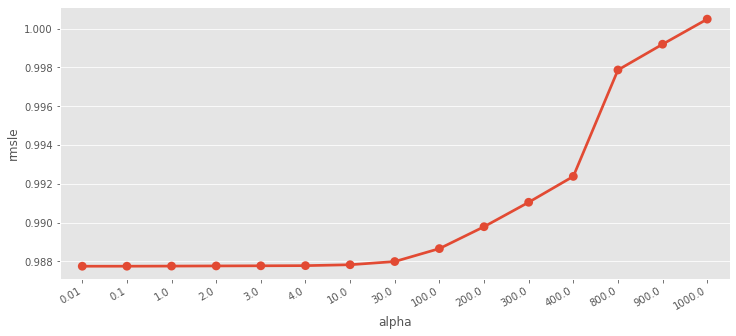

In [19]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## 라쏘 Regularization Model - Lasso
* 선형회귀의 Regularization(규제)를 적용하는 대안
* 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
* 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
* alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
* 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025
* max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [20]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9803727821457642


,alpha,rmsle
0,10.000000,1.397124
1,1.000000,1.071947
2,0.500000,1.062110
3,0.333333,1.060815
4,0.250000,1.061139


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

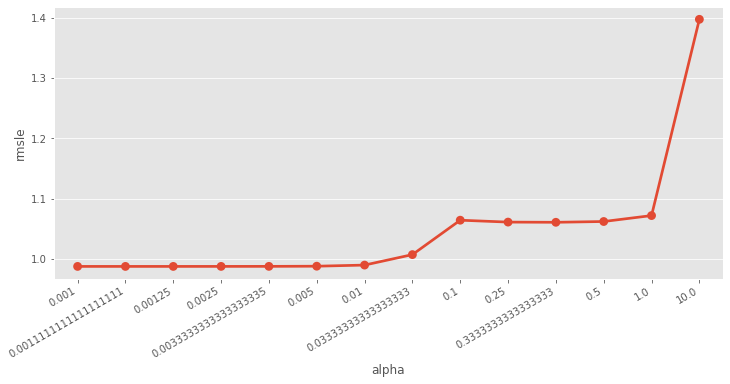

In [21]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## 앙상블모델 - 랜덤포레스트 
### Ensemble Models - Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10752454008744443


## 앙상블모델 - 그라디언트 부스트
### Ensemble Model - Gradient Boost
* 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
* 회귀와 분류에 모두 사용할 수 있음
* 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
* 무작위성이 없고 강력한 사전 가지치기가 사용 됨
* 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
* learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
* n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
* max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.21357403727840332


<AxesSubplot:ylabel='Density'>

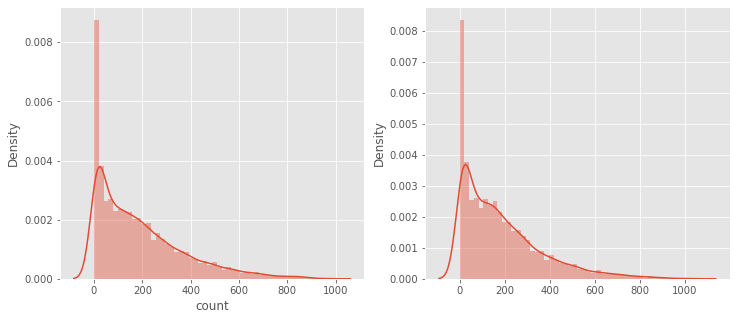

In [26]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

## Submit

In [28]:
submission = pd.read_csv("file-path/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.227543
1,2011-01-20 01:00:00,6.296610
2,2011-01-20 02:00:00,4.259238
3,2011-01-20 03:00:00,2.666615
4,2011-01-20 04:00:00,2.295918


In [29]:
submission.to_csv(f"file-path/Score_{score:.5f}_submission.csv", index=False)

참고 : 
* [EDA & Ensemble Model (Top 10 Percentile) | Kaggle](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)
* [How to finish top 10 percentile in Bike Sharing Demand Competition In Kaggle? (part -1)](https://medium.com/@viveksrinivasan/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-1-c816ea9c51e1)
* [How to finish top 10 percentile in Bike Sharing Demand Competition In Kaggle? (part -2)](https://medium.com/@viveksrinivasan/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-2-29e854aaab7d)
* [Kaggle Bike Sharing Demand Prediction - How To Get In Top 5 Of Competition](https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/)